# Project 1

Max Schrader

AEM 591

#### Resources

https://towardsdatascience.com/on-simulating-non-linear-dynamic-systems-with-python-or-how-to-gain-insights-without-using-ml-353eebf8dcc3

## Install the Required Packages

In [1]:
# %pip install pint
# %pip install numpy
# %pip install plotly
# %pip install prettytable

In [35]:
import os
from dataclasses import dataclass
import math
from typing import Union

import pint
import numpy as np
from scipy.integrate import solve_ivp, odeint
from scipy.signal import StateSpace, lsim
from prettytable import PrettyTable
import plotly.graph_objects as go
from plotly.tools import make_subplots
# import control

## Helper Functions

In [3]:
ureg = pint.UnitRegistry()

In [4]:
def pretty_print(array: np.array, headers: list) -> None:
    x = PrettyTable()
    x.field_names = headers
    if len(headers) > 1 and len(array.shape) < 2:
        x.add_row(list(map(lambda x: round(x, 3), array)))
    else:
        for row in array:
#             if len(array.shape) > 1:
            x.add_row(list(map(lambda x: round(x, 3), row)) 
                  if len(array.shape) > 1 else [round(row, 3)])

#             x.add_row(round(row, 3))
    print(x)

### Constants

In [5]:
@dataclass
class Elevator:

    I_m = 700 * ureg.kilogram * ureg.meter ** 2
    K = 100 * ureg.newton * ureg.meter / ureg.ampere
    K_v = 100 * ureg.volt * ureg.second
    L = 0.4 * ureg.H
    m = 500 * ureg.kg
    g = 1 * ureg.gravity
    W = 300 * ureg.kilogram * 1 * ureg.gravity
    r_0 = 3 * ureg.meter
    delta_c = 0.05 * ureg.meter
    R_0 = 5 * ureg.ohm
    delta_r = 5 * ureg.ohm
    t_r = 3 * ureg.second
    
    def r_t(self, x=None, *args, **kwargs) -> pint.unit:
        x = x or self.x
        return ((self.delta_c * x / math.pi + self.r_0 ** 2) ** (1/2)).to('meter') 
    
    def R_t(self, t: float) -> pint.unit:
        return (self.R_0 + self.delta_r * (1 - math.exp(-t * ureg.second / (self.t_r)))).to('ohm')
    

### Given Equations

## Problem 1

Setup two functions to compute the state and outputs in Python using the state-space system
representation above

In [6]:
# g = lambda x:  
class NonLinearElevator(Elevator):
    def __init__(self, x: float, doublet_d_t: float=None, doublet_c: float=None):
        self.doublet_c = doublet_c if isinstance(doublet_c, ureg.Quantity) else doublet_c * ureg.volt if doublet_c else None
        self.doublet_d_t = doublet_d_t.to('second').magnitude if isinstance(doublet_d_t, ureg.Quantity) else doublet_d_t if doublet_d_t else None
        self.x = x * ureg.meter
    
    def _f2_constant(self, r: float) -> float:
        return 1 / (self.m * r - (self.I_m / r))
    
    def f(self, ) -> object:
        # return inner function because scipy odeint doesn't like OOP 
        def _f(t: float, x_t: np.array) -> np.array:
            x_dot = np.zeros(4)
            
            # Time Variant Fns
            v_t = self.doublet(t)
            
            # X variant FN
            r_t = self.r_t(x_t[0] * ureg.meter)
            
            x_dot[0] = x_t[1]
            
            x_dot[1] = (self._f2_constant(r_t) * \
                (
                    (self.W * r_t - self.m * self.g * r_t + self.K * (x_t[2] * ureg.amp)) - 
                        (self.I_m * self.delta_c * (x_t[1] * ureg.mps)**2) / \
                        (2 * math.pi * r_t ** 3)
                )
                       ).to('m/s^2').magnitude
            
            x_dot[2] = \
                (v_t / self.L - \
                ((self.R_t(t)) / self.L * (x_t[2] * ureg.ampere)) + \
                ((self.K_v * (x_t[1] * ureg.mps)) / (self.L * r_t))).to('A/s').magnitude
            
            x_dot[3] = (self.delta_c * (x_t[1] * ureg.mps) / (2 * math.pi * r_t)).to('m/s').magnitude
            
#             print(x_dot)

#             if x_t[0] <= 0:
#                 # Then the elevator is sitting on the ground and physically can't go lower?
#                 x_dot[0] = max(0, x_t[1])
#                 # the acceleration can't be negative
#                 #                 x_dot[1] = max(0, x_dot[1])
#                 # the cable can't unwind
#                 x_dot[3] = max(0, x_dot[3])

            return x_dot
        return _f
    
    def out(self, ) -> object:
        def _out(x_t: np.array, t: float) -> np.array:
            out_dot = np.zeros(2)
            out_dot[0] = x_t[0]
            out_dot[1] = x_t[1]
            return out_dot
        return _out
    
    def doublet(self, t: float) -> ureg.volt:
        return {
            0: 0 * ureg.volt,
            1: self.doublet_c,
            2: -1 * self.doublet_c,
            3: 0 * ureg.volt,
        }[min(int(t // (self.doublet_d_t / 2)), 3)].to('V')

## Problem 2

ompute the linearized state-space system about three equilibrium/trim points at 𝑥 = 0,
15, and 30 m for a steady-state value of 𝑅 = 𝑅0 +𝛿𝑅, i.e. 𝑅(𝑡) as 𝑡 → ∞. Analyze the
controllability, observability, and stability in Python for the linearized system.

https://www.wolframalpha.com/input/?i2d=true&i=partial+derivative+of+%5C%2840%29Divide%5B1%2Cm*r+-+Divide%5BI%2Cr%5D%5D%5C%2841%29%5C%2840%29W*r+-+m*g*r+%2B+K*j+-+Divide%5BI+*+%CE%B4*Power%5Bx%2C2%5D%2C2+*+%CF%80*Power%5Br%2C3%5D%5D%5C%2841%29+with+respect+to+r

In [202]:
class LinearElevator(NonLinearElevator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
#         self.x = x * ureg.meter
        
    def R_t(self, *args, **kwargs) -> pint.unit:
        return 10 * ureg.ohm
    
    """ Doing the linearized points as @property is not computationaly 
        efficient but makes the code most readable for me """
    @property
    def x_dot_bar(self, ) -> ureg.meter:
        return 0 * ureg.meter
    
    @property
    def v_bar(self, ) -> ureg.volt:
        return (((self.m * self.g - self.W) * (self.R_0 + self.delta_r)) / self.K * self.r_t()).to('V') 
    
    @property
    def i_bar(self, ) -> ureg.ampere:
        return (self.v_bar / (self.R_0 + self.delta_r)).to('A')
    
    @property
    def r_bar(self, ) -> ureg.meter:
        return (self.K / (self.m * self.g - self.W) * self.i_bar).to('meter')
    
    def df1_dx(self, *args, **kwargs) -> np.array:
        return np.array(
        [
            0, 
            1, 
            0, 
            0
        ])
    
    def df2_dx(self, ) -> np.array:
        return np.array(
            [
                0, 
                0, # (self.I_m * self.delta_c * x_t[1]) / (math.pi * self.m * r_t **4 + x_t[2] * math.pi * r_t ** 2) commented out because x_bar = 0
                ((self.K * self.r_bar) / (self.m * self.r_bar**2 - self.I_m)).to('m/s^2/A').magnitude,
                ((2 * self.I_m * math.pi * self.r_bar ** 4 * (self.g * self.m - self.W)) / (math.pi * self.r_bar ** 3 * (self.m * self.r_bar**2 - self.I_m) ** 2)).to('m/s^2/m').magnitude
            ]
        )
    
    def df3_dx(self, ) -> np.array:
        return np.array(
            [
                0,
                ((-1 * self.K) / (self.L * self.r_bar)).to('A/m').magnitude,
                (-1 * self.R_t() / self.L).to('1/s').magnitude,
                0 # because x_bar = 0
            ]
        )
    
    def df4_dx(self, ) -> np.array:
        return np.array(
            [
                0,
                (self.delta_c / (2 * math.pi * self.r_bar)).to('dimensionless').magnitude,
                0,
                0
            ]
        )
    
    @property
    def A(self, ) -> np.array:
        return np.asarray(
            [
                self.df1_dx(),
                self.df2_dx(),
                self.df3_dx(),
                self.df4_dx()
            ]
        )
    
    @property
    def B(self, ) -> np.array:
        return np.asarray(
            [[
                0,
                0,
                (1 / self.L).to('A/s/V').magnitude,
                0
            ]]
        )
    
    @property
    def C(self, ) -> np.array:
        return np.asarray(
            [
                [1, 0, 0, 0],
                [0, 1, 0, 0]
            ]
        )
    
    @property
    def D(self, ) -> np.array:
        return np.asarray(
            [[0, 0,]]
        )

### Checking the Units

In [143]:
elevator = LinearElevator(x=100)
# this should never be done
self = elevator

#### df2_dx

In [203]:
r_const = ((2 * self.I_m * math.pi * self.r_bar ** 4 * (self.g * self.m - self.W)) / (math.pi * self.r_bar ** 3 * (self.m * self.r_bar**2 - self.I_m) ** 2)).to('m/s^2/m')
i_const = ((self.K * self.r_bar) / (self.m * self.r_bar**2 - self.I_m)).to('m/s^2/A')

In [204]:
(i_const * 1 * ureg.amp)

0.07081430827500501 <Unit('meter / second ** 2')>

In [205]:
final = ((i_const * 1 * ureg.ampere) + (r_const * 1 * ureg.meter))
assert final.units == 1 * ureg.mps / ureg.second

#### df3_dx

In [185]:
x_dot_const = ((-1 * self.K) / (self.L * self.r_bar)).to('A/m')
i_const = (self.R_t() / self.L).to('1/s')

In [186]:
final = (x_dot_const * 1 * ureg.mps) + (i_const * 1 * ureg.ampere)
assert final.units == 1 * ureg.amp / ureg.second

#### df4_dx

In [193]:
x_dot_const = (self.delta_c / (2 * math.pi * self.r_bar)).to('dimensionless')

In [194]:
final = x_dot_const * 1 * ureg.mps
assert final.units == 1 * ureg.mps

### State Space at $x = 0$

In [16]:
elevator = LinearElevator(x=0)
pretty_print(elevator.A, ['x', 'x_dot', 'i', 'r'])

+-----+---------+-------+-------+
|  x  |  x_dot  |   i   |   r   |
+-----+---------+-------+-------+
| 0.0 |   1.0   |  0.0  |  0.0  |
| 0.0 |   0.0   | 0.079 | 0.058 |
| 0.0 | -83.333 |  25.0 |  0.0  |
| 0.0 |  0.003  |  0.0  |  0.0  |
+-----+---------+-------+-------+


In [17]:
pretty_print(elevator.B, ['v'])

+-----+
|  v  |
+-----+
| 0.0 |
| 0.0 |
| 2.5 |
| 0.0 |
+-----+


In [18]:
elevator.v_bar.to('V')

588.399 <Unit('volt')>

#### Finding the stability

In [19]:
np.linalg.eigvals(elevator.A)

array([ 0.00000000e+00,  2.47340121e+01,  2.66573018e-01, -5.85073228e-04])

In [20]:
np.linalg.matrix_rank(elevator.A)

3

## Problem 3

Simulate the nonlinear system with doublet commands on $\dot{v}$, both up and down, for initial conditions close and far from the linearized states, but including $t$. Use input values which keep the elevator velocity reasonable

In [24]:
x = 0
doublet_magnitude = LinearElevator(x).v_bar * 4
doublet_dt = 1
t = np.linspace(0, 2, 100)

elevator = NonLinearElevator(x, doublet_c=doublet_magnitude, doublet_d_t=doublet_dt)

# compose the initial conditions
x0 = np.array([elevator.x.magnitude, 0, 0, elevator.r_t(elevator.x).magnitude])

print("Doublet C", doublet_magnitude)
print("Doublet dt", doublet_dt)

print("X0 = ")
pretty_print(x0, headers=['x', 'x_dot', 'i', 'r'])

Doublet C 2353.596 volt
Doublet dt 1
X0 = 
+-----+-------+-----+-----+
|  x  | x_dot |  i  |  r  |
+-----+-------+-----+-----+
| 0.0 |  0.0  | 0.0 | 3.0 |
+-----+-------+-----+-----+


In [25]:
# s = solve_ivp(elevator.f(), y0=x0, t_span=(0, 20),)
s = odeint(elevator.f(), y0=x0, t=t, tfirst=True)

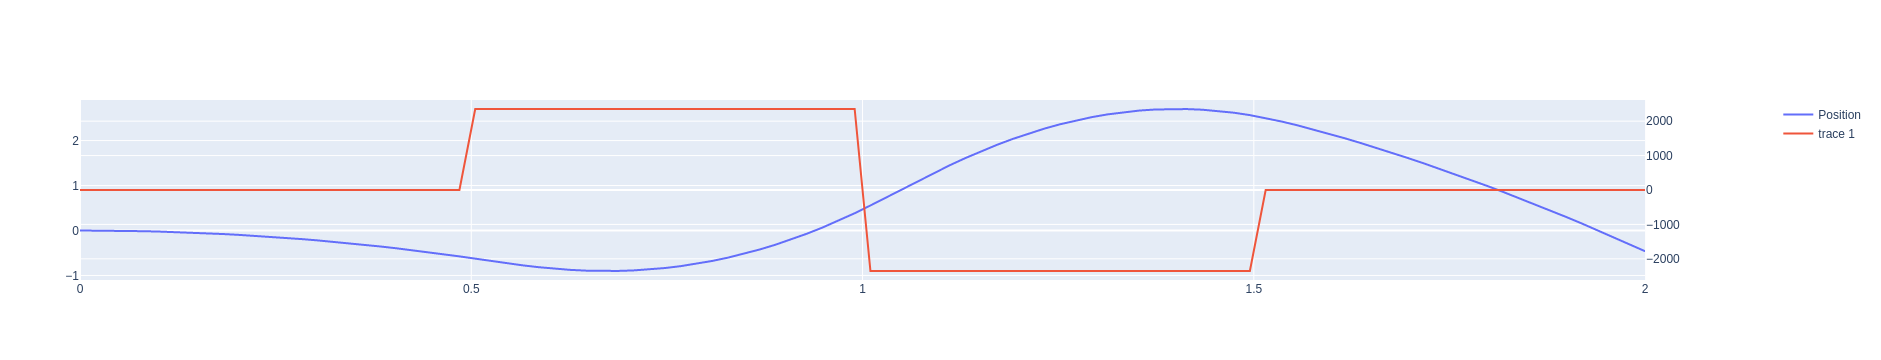

In [27]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
# len(s)
fig.add_trace(go.Scatter(x=t, y=[y[0] for y in s], name="Position"))
fig.add_trace(go.Scatter(x=t, y=[elevator.doublet(_t) for _t in t]), secondary_y=True)
# isinstance(elevator.doublet_c, ureg.Quantity)

## Problem 4

Simulate the linearized system with doublet commands on $dot{v}$, both up and down, for initial conditions close to the linearized states. Use input values which keep the elevator velocity reasonable

### Position $x = 0$

In [199]:
x = 0

doublet_magnitude = LinearElevator(x).v_bar / 10
doublet_dt = 5
t = np.linspace(0, 8, 1000)

elevator = LinearElevator(x=0, doublet_c=doublet_magnitude, doublet_d_t=doublet_dt)

U = np.asarray(list(elevator.doublet(_t).magnitude for _t in t))

elevator_ss = StateSpace(elevator.A, elevator.B.T, elevator.C, elevator.D.T)

In [200]:
_, y, s = lsim(elevator_ss, U, t)

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/plotly/tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



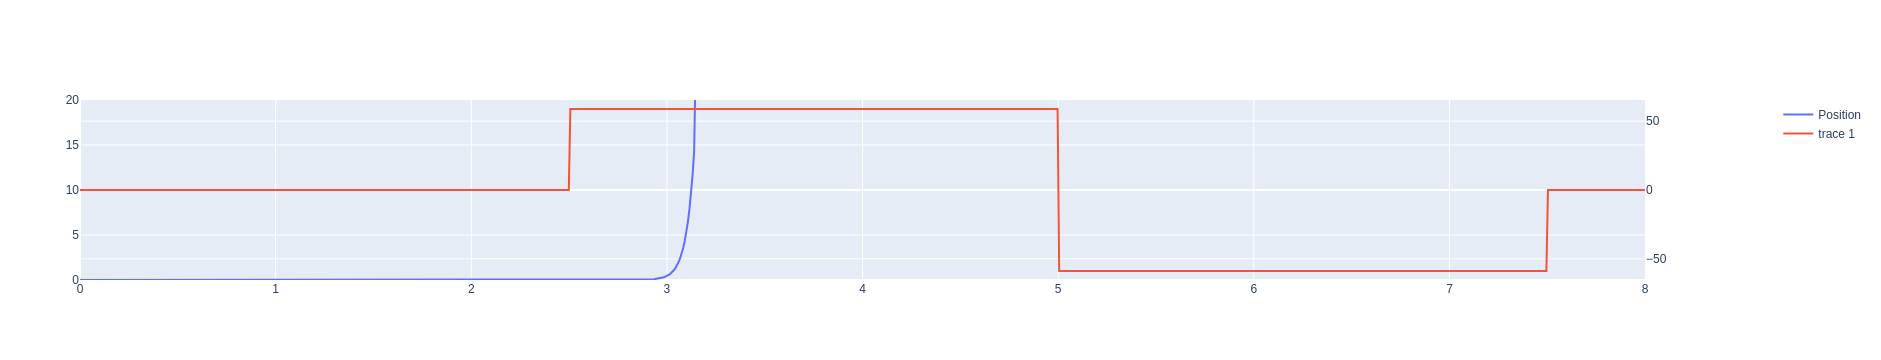

In [201]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
# len(s)
fig.add_trace(go.Scatter(x=t, y=[_s[3] for _s in s], name="Position"))
fig.add_trace(go.Scatter(x=t, y=U), secondary_y=True)
# isinstance(elevator.doublet_c, ureg.Quantity)
fig.update_layout(yaxis=dict(range=[0, 20]))

## Problem 5

Write a few paragraphs summarizing the results of these simulations and any analysis. Make sure to compare the linear simulations to the nonlinear.